In [1]:
import sys; sys.path.append('../../wwa/'); from wwa import *
import warnings
warnings.filterwarnings("ignore", message = ".+lines.+")

Xn, Xx, Yn, Yx = [17,42,-30,-5]
xn, xx, yn, yx = [19,40.5,-27.5,-15]

sf = gpd.read_file("sf_drought")
sf = sf.dissolve().explode()

/tmp/ipykernel_271307/3719788089.py:9: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf = sf.dissolve().explode()


# Maps of fitted trends & results

## [HPC] Get gridded data

In [ ]:
chirps = xr.concat([xr.open_dataset(fnm).groupby("time.season")["DJF"].sel(longitude = slice(xn,xx), latitude = slice(yn,yx)) for fnm in sorted(glob.glob("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/chirps_05/*.nc"))], "time")
chirps = chirps.rename(precip = "pr", longitude = "lon", latitude = "lat")

chirps_qs = chirps.pr.resample(time = "QS-DEC").sum()
chirps_qs = chirps_qs.where(chirps_qs.sum("time") > 0)

chirps_qs = chirps_qs.groupby("time.season")["DJF"].sel(time = slice("1981",None))

chirps_qs.to_netcdf("sa-drought_chirps.nc")

In [ ]:
mswep = xr.open_dataset('../../00_WWA_project_folder/ephemeral/southernafrica/mswep/precip_mswep_southernafrca_1979-2024.nc').pr.sel(time = slice("1979-03", None))
mswep_qs = mswep.resample(time = "QS-DEC").sum()
mswep_qs = mswep_qs.where(mswep_qs.sum("time") > 0).groupby("time.season")["DJF"]
mswep_qs.to_netcdf("sa-drought_mswep.nc")

In [2]:
era5 = decode_times(xr.open_dataset("era5_tp_15-45E_-30--5N_su.nc", decode_times = False)).tp.rename("pr").sel(time = slice("1950-03", None))
era5 = era5 * era5.time.dt.daysinmonth
era5_qs = era5.resample(time = "QS-DEC").sum().groupby("time.season")["DJF"].rename("pr")
era5_qs.to_netcdf("sa-drought_era5.nc")

In [68]:
tamsat = xr.open_mfdataset("../../00_WWA_project_folder/ephemeral/southernafrica/TAMSAT/origfiles/rfe*_daily_SouthernAfrica.v3.1.nc").rfe.sel(lon = slice(xn,xx), lat = slice(yx,yn))
tamsat_qs = tamsat.resample(time = "QS-DEC").sum().groupby("time.season")["DJF"].sel(time = slice("1983",None))
tamsat_qs.to_netcdf("sa-drought_tamsat.nc")

In [ ]:
nino34 = xr.open_dataset("../10_misc/detrended_nino34/ersst_nino34_detrended.nc").nino34.resample(time = "QS-DEC").mean().groupby("time.season")["DJF"].isel(time = slice(1,None))
nino34.assign_coords(time = nino34.time.dt.year).rename(time = "year").to_pandas().to_csv("nino34_djf.csv")

## Flatten data for processing

In [3]:
for ds in ["tamsat"]:#["chirps", "mswep", "era5"]:
    da = wrap_lon(xr.open_dataset("sa-drought_"+ds+".nc")).pr.sel(lon = slice(xn,xx), lat = slice(yn,yx))
    da = da.assign_coords(time = da.time.dt.year).rename(time = "year")
    
    # remove any sea surface points
    rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(da.lon, da.lat).sum("region")
    da = da.where(rm == 1)

    da_df = da.stack(xy = ["lat", "lon"]).dropna("xy", "all").to_pandas()
    
    # if too many cells, split into subsets to avoid crashing R
    if da_df.shape[1] > 2500:
        for i in range(int(np.ceil(da_df.shape[1] / 2500))):
            da_df.iloc[:,slice(i*2500,(i+1)*2500)].to_csv(ds+"_pr-djf_flattened-"+str(i+1).rjust(2,"0")+".csv")
    else:
        da_df.to_csv(ds+"_pr-djf_flattened.csv")

## Reconstruct fitted values into maps

In [5]:
def vec2map(x, mask):
    
    # reconstruct vector into map
    # create an empty map with NA in same cells as masks
    arr = mask.where(np.isnan(mask), 0)
    
    # get coordinates of non-empty cells
    px = np.argwhere(~np.isnan(mask.values))
    
    # Transfer vector values into non-empty cells in array
    if len(px) == len(x):
        for i in list(range(len(px))): arr[px[i,0], px[i,1]] = x[i]
        return arr
    else:
        print(str(len(x))+" values, but "+str(len(px))+" cells")
        return

In [6]:
ds = "era5"

df = merge_byindex([pd.read_csv(fnm, index_col = 0) for fnm in sorted(glob.glob(ds+"_pr-djf_fitted-*.csv"))])
clear_output(wait = False) # because there will be a LOT of warnings

tmplt = wrap_lon(xr.open_dataset("sa-drought_"+ds+".nc")).pr.isel(time = 0, drop = True).sel(lon = slice(xn,xx), lat = slice(yn,yx))
rm = regionmask.defined_regions.natural_earth_v5_0_0.countries_110.mask_3D(tmplt.lon, tmplt.lat).sum("region")
tmplt = tmplt.where(rm == 1)
    
mdl_res = xr.merge([vec2map(df.loc[r], tmplt).rename(r) for r in df.index])
mdl_res.to_netcdf("fitted_"+ds+"-gridded.nc")

# Maps of results

In [7]:
res = {ds : xr.open_dataset("fitted_"+ds+"-gridded.nc") for ds in ["chirps", "era5", "mswep"]}

In [8]:
res_kwargs = {"alpha_gmst" : {"plot_kwargs" : {"cmap" : "BrBG", "add_colorbar" : False, "vmin" : -200, "vmax" : 200},
                              "suptitle" : "Change in DJF precipitation per deg GMST increase",
                              "cbar_label" : "Change in precipitation (mm)"},
              "alpha_nino" : {"plot_kwargs" : {"cmap" : "BrBG", "add_colorbar" : False, "vmin" : -200, "vmax" : 200},
                              "suptitle" : "Change in DJF precipitation per deg Nino increase",
                              "cbar_label" : "Change in precipitation (mm)"},
              "dI_rel_hist" : {"plot_kwargs" : {"cmap" : "BrBG", "add_colorbar" : False, "vmin" : -50, "vmax" : 50},
                               "suptitle" : "Relative change in precipitation attributable to 1.2deg increase in GMST",
                               "cbar_label" : "Change in precipitation (%)"},
              "dI_rel_neut" : {"plot_kwargs" : {"cmap" : "BrBG", "add_colorbar" : False, "vmin" : -50, "vmax" : 50},
                               "suptitle" : "Relative change in precipitation attributable to 2023-4 El Nino",
                               "cbar_label" : "Change in precipitation (%)"},
              "return_period" : {"plot_kwargs" : {"cmap" : "viridis", "add_colorbar" : False, "vmin" : 0, "vmax" : 50},
                                 "suptitle" : "Return period of DJF23-24 precipitation",
                                 "cbar_label" : "Return period (years)"}}

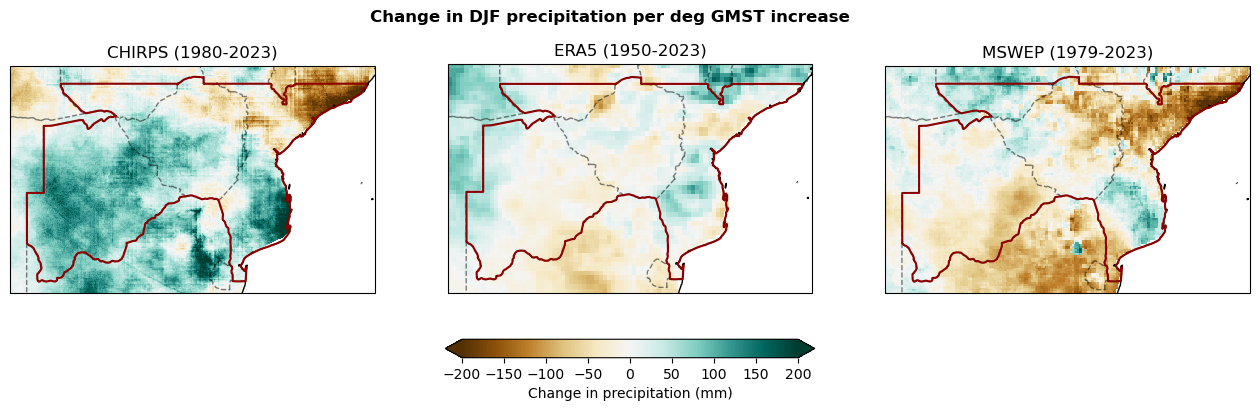

In [10]:
rnm = "alpha_gmst"

fig, axs = plt.subplots(ncols = 3, figsize = (16,4), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

ax = axs[0]
res["chirps"][rnm].plot(ax = ax, **res_kwargs[rnm]["plot_kwargs"])
ax.set_title("CHIRPS (1980-2023)")

ax = axs[1]
res["era5"][rnm].plot(ax = ax, **res_kwargs[rnm]["plot_kwargs"])
ax.set_title("ERA5 (1950-2023)")

ax = axs[2]
cbar = res["mswep"][rnm].plot(ax = ax, **res_kwargs[rnm]["plot_kwargs"])
ax.set_title("MSWEP (1979-2023)")

for ax in axs:
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    sf.boundary.plot(ax = ax, color = "darkred")
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.06, extend = "both", label = res_kwargs[rnm]["cbar_label"])

plt.suptitle(res_kwargs[rnm]["suptitle"], fontweight = "bold")

plt.savefig("gridded-res_"+rnm+".png")